**Executed:** Fri Feb  7 05:23:35 2020<br>**Duration:** 658 seconds.<br>**Autogenerated from:** [Base Experiment.ipynb](saved experiments/No Augmentation + Baseline Model + Dropout + epoch30.ipynb)

---

In [1]:
# NOTEBOOK parameters
# see nbrun docs on github

IMG_SHAPE = (150,150)
BATCH_SIZE = 32
EPOCH = 30
MODEL = 'Lite Test'
DATA_GEN_CONFIG = 'Baseline Augmentation'

In [2]:
# Cell inserted during automated execution.
DATA_GEN_CONFIG = 'No Augmentation'
MODEL = 'Baseline Model + Dropout'
EPOCH = 30

In [3]:
!curl -L -o noahs_utils.py https://gist.github.com/bantucaravan/1956003e25c056c550a088542b41dc91/raw/noahs_utility_funcs.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


100 12548  100 12548    0     0  35295      0 --:--:-- --:--:-- --:--:-- 35295


In [4]:
import os
import glob
import re
import datetime as dt
from collections import defaultdict
import sys
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

#import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint#, TensorBoard
from tensorflow.keras.layers import Dropout, Conv2D, MaxPooling2D, Flatten, Dense

from noahs_utils import *
import build_data_gens
import build_models

In [5]:
if False:
    import noahs_utils
    importlib.reload(noahs_utils)

**Data** from https://www.kaggle.com/asdasdasasdas/garbage-classification

Get number of images in each class folder

In [6]:
img_dir = '/Users/noahchasekmacfoy/Desktop/local projects/Trash-life/data/Garbage Classification Dataset/IMAGES'
tot_len = 0
for _dir in [i for i in os.listdir(img_dir) if not i.startswith('.')]:
    _len = len(os.listdir(os.path.join(img_dir, _dir)))
    tot_len += _len
    print(_dir, ': ', _len)
print(tot_len)

paper :  594
metal :  410
cardboard :  403
trash :  137
glass :  501
plastic :  482
2527


Listed test/val/train split from txt files

In [7]:
#file = '../data/Garbage Classification Dataset/one-indexed-files-notrash_test.txt'
files = glob.glob('../data/Garbage Classification Dataset/*_*.txt')
files = {re.findall(r'.*_(\w*).txt',f)[0]: pd.read_csv(f, sep=' ', header=None) for i, f in enumerate(files)}

Create df listing train/val/test split

In [8]:
df = pd.concat(files.values(), axis=0, keys=files.keys()).reset_index(level=0)
df.columns = ['split', 'img', '1-indexed-label']
df.index = range(len(df))
df['label'] = df['img'].str.extract(r'([a-z]+)\d+.jpg')
df

,split,img,1-indexed-label,label
0,test,paper70.jpg,2,paper
1,test,paper380.jpg,2,paper
2,test,cardboard31.jpg,3,cardboard
3,test,glass12.jpg,1,glass
4,test,paper169.jpg,2,paper
...,...,...,...,...
2522,train,cardboard6.jpg,3,cardboard
2523,train,glass283.jpg,1,glass
2524,train,metal335.jpg,5,metal
2525,train,plastic133.jpg,4,plastic


In [9]:
print('total listed images:', df.shape[0],'\n')
print('test/val/train split:')
df.groupby('split').size()/df.shape[0]

total listed images: 2527 

test/val/train split:


split
test     0.170558
train    0.699644
val      0.129798
dtype: float64

Create symlink dirs representing Train / Val / Test

In [10]:
tmp_dir = '../data/Garbage Classification Dataset/tmp images/'
# create dirs
for split in df.split.unique():
    for label in df.label.unique():
        os.makedirs(os.path.join(tmp_dir,split,label), exist_ok=True)
for i in df.index:
    try:
        src = os.path.join(img_dir, df.loc[i, 'label'], df.loc[i, 'img'])
        dst = os.path.join(tmp_dir, df.loc[i, 'split'], df.loc[i, 'label'], df.loc[i, 'img'])
        #print('src:', os.path.exists(src))
        #print('dst:', os.path.exists(dst))
        os.symlink(src, dst)
    except FileExistsError:
        pass

Set up train / val data generators

In [11]:
#### Import pre-configed data_gens
train_gen_config, val_gen_config = build_data_gens.get_gen_config(DATA_GEN_CONFIG)


In [12]:
train_gen = train_gen_config.flow_from_directory(os.path.join(tmp_dir,'train'),
                                                target_size=IMG_SHAPE,
                                                follow_links=True)
val_gen = val_gen_config.flow_from_directory(os.path.join(tmp_dir,'val'),
                                                target_size=IMG_SHAPE,
                                                follow_links=True)

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.


In [13]:
len(val_gen)

11

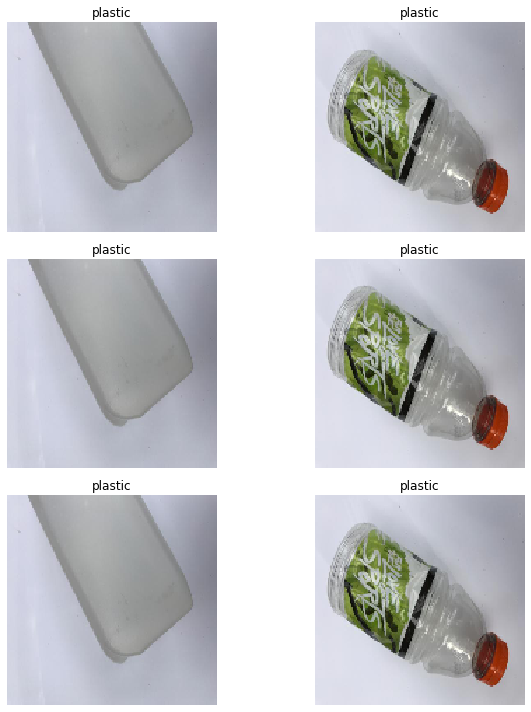

In [14]:
#Look at n random augmentations of the first 2 images from the first batch
#Issue: insure viz of each class transformed
classes =list(train_gen.class_indices.keys())
n=3
fig, axes = plt.subplots(n,2, figsize=(10,10))
for i in range(n):
    batch = train_gen[0] # returns first batch
    ax = plot_image(batch[0][0], ax= axes[i, 0])
    cls = classes[np.argmax(batch[1][0])]
    ax.set(title = cls)
    ax.axis('off')
    #plt.show()
    ax = plot_image(batch[0][1], ax=axes[i, 1])
    cls = classes[np.argmax(batch[1][1])]
    ax.set(title = cls)
    ax.axis('off') 
plt.tight_layout()
    #plt.show()

In [15]:
len(train_gen)

56

In [16]:
train_gen[0][0].shape

(32, 150, 150, 3)

In [17]:
train_gen[55][0].shape

(8, 150, 150, 3)

### Build model

Baseline  
Baseline + Dropout  
Baseline + Data Augmentation  
Baseline + Dropout + Data Augmentation  

In [18]:
ts = dt.datetime.now().strftime('%Y-%m-%d_%Hh%Mm%Ss')
ts

'2020-02-07_05h23m44s'

In [19]:
# Callbacks
bestmodelpath = '../saved models/model_epoch{epoch:02d}_{val_loss:.2f}_%s.h5' %(ts)
best_model = ModelCheckpoint(bestmodelpath, monitor='val_loss', verbose=1, save_best_only=True)

callback_list=[best_model]

In [20]:
#### Import model

build_models.set_img_shape(IMG_SHAPE)

model = build_models.get_model(MODEL)


Available Models:
 ['Baseline Model', 'Baseline Model + Dropout', 'Smaller Baseline Model', 'Lite Test', 'Inception-ResNet V2 Model']


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)      

In [22]:
%%time
print('Starting to fit model...')
history = model.fit(train_gen,
           validation_data=val_gen,
           steps_per_epoch=len(train_gen),
           validation_steps=len(val_gen),
           epochs=EPOCH,
           callbacks=callback_list,
           verbose=.5
          )

Starting to fit model...
  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 56 steps, validate for 11 steps
Epoch 1/30



Epoch 00001: val_loss improved from inf to 1.61638, saving model to ../saved models/model_epoch01_1.62_2020-02-07_05h23m44s.h5
Epoch 2/30



Epoch 00002: val_loss improved from 1.61638 to 1.54550, saving model to ../saved models/model_epoch02_1.55_2020-02-07_05h23m44s.h5
Epoch 3/30



Epoch 00003: val_loss improved from 1.54550 to 1.41588, saving model to ../saved models/model_epoch03_1.42_2020-02-07_05h23m44s.h5
Epoch 4/30



Epoch 00004: val_loss improved from 1.41588 to 1.33101, saving model to ../saved models/model_epoch04_1.33_2020-02-07_05h23m44s.h5
Epoch 5/30



Epoch 00005: val_loss improved from 1.33101 to 1.16512, saving model to ../saved models/model_epoch05_1.17_2020-02-07_05h23m44s.h5
Epoch 6/30



Epoch 00006: val_loss improved from 1.16512 to 1.13896, saving model to ../saved models/model_epoch06_1.14_2020-02-07_05h23m44s.h5
Epoch 7/30



Epoch 00007: val_loss improved from 1.13896 to 1.06180, saving model to ../saved models/model_epoch07_1.06_2020-02-07_05h23m44s.h5
Epoch 8/30



Epoch 00008: val_loss did not improve from 1.06180
Epoch 9/30



Epoch 00009: val_loss did not improve from 1.06180
Epoch 10/30



Epoch 00010: val_loss improved from 1.06180 to 1.00001, saving model to ../saved models/model_epoch10_1.00_2020-02-07_05h23m44s.h5
Epoch 11/30



Epoch 00011: val_loss did not improve from 1.00001
Epoch 12/30



Epoch 00012: val_loss did not improve from 1.00001
Epoch 13/30



Epoch 00013: val_loss did not improve from 1.00001
Epoch 14/30



Epoch 00014: val_loss did not improve from 1.00001
Epoch 15/30



Epoch 00015: val_loss did not improve from 1.00001
Epoch 16/30



Epoch 00016: val_loss did not improve from 1.00001
Epoch 17/30



Epoch 00017: val_loss did not improve from 1.00001
Epoch 18/30



Epoch 00018: val_loss did not improve from 1.00001
Epoch 19/30



Epoch 00019: val_loss did not improve from 1.00001
Epoch 20/30



Epoch 00020: val_loss did not improve from 1.00001
Epoch 21/30



Epoch 00021: val_loss did not improve from 1.00001
Epoch 22/30



Epoch 00022: val_loss did not improve from 1.00001
Epoch 23/30



Epoch 00023: val_loss did not improve from 1.00001
Epoch 24/30



Epoch 00024: val_loss did not improve from 1.00001
Epoch 25/30



Epoch 00025: val_loss did not improve from 1.00001
Epoch 26/30



Epoch 00026: val_loss did not improve from 1.00001
Epoch 27/30



Epoch 00027: val_loss did not improve from 1.00001
Epoch 28/30



Epoch 00028: val_loss did not improve from 1.00001
Epoch 29/30



Epoch 00029: val_loss did not improve from 1.00001
Epoch 30/30



Epoch 00030: val_loss did not improve from 1.00001
CPU times: user 1h 13min 57s, sys: 4min 24s, total: 1h 18min 21s
Wall time: 10min 34s


### Evaluate Model

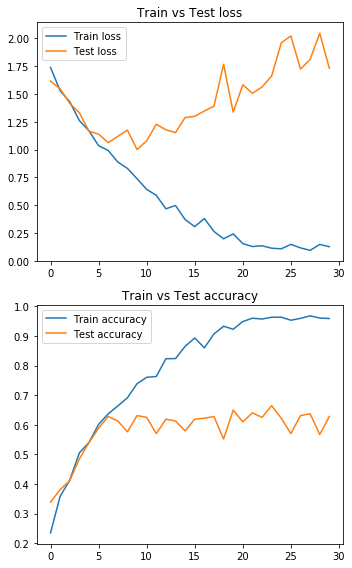

In [23]:
imgpath = '../figs/Train Test %s %s.png' %('accuracy', ts)
plot_tf_training(history, metric='accuracy', save=imgpath)

In [24]:
#ts = '2020-02-07_00h05m06s'
#sorted(glob.glob('../saved models/model_*_2020-02-06_23:35:05.h5'))[-1]
get_loss = lambda x: float(re.findall(r'_(\d\.\d{2})_', x)[0])
pat = '../saved models/model_epoch*_*_%s.h5' %(ts)
bestmodelpath = sorted(glob.glob(pat), key=get_loss)[0]
print(bestmodelpath)

../saved models/model_epoch10_1.00_2020-02-07_05h23m44s.h5


In [25]:
# write something to delete albut best?? (always latest?) model path
# glob for best model path around epoch????
bestmodel = load_model(bestmodelpath)

In [26]:
ytrue = val_gen.classes[val_gen.index_array]
proba_preds = bestmodel.predict(val_gen, steps=len(val_gen))
preds = np.argmax(proba_preds, axis=1)

In [27]:
out = metrics_report(ytrue, preds, classnames=val_gen.class_indices.keys())
out

,cardboard,glass,metal,paper,plastic,trash,accuracy,macro avg,weighted avg
precision,0.689655,0.590909,0.550000,0.823529,0.574074,0.363636,0.631098,0.598634,0.641727
recall,0.869565,0.600000,0.589286,0.674699,0.508197,0.470588,0.631098,0.618722,0.631098
f1-score,0.769231,0.595420,0.568966,0.741722,0.539130,0.410256,0.631098,0.604121,0.632235
support,46.000000,65.000000,56.000000,83.000000,61.000000,17.000000,0.631098,328.000000,328.000000


In [28]:
val_gen.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

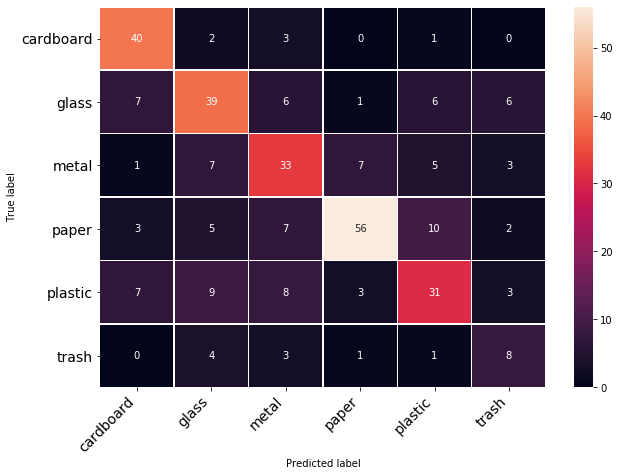

In [29]:
cm = confusion_matrix(ytrue, preds, class_names=val_gen.class_indices.keys())

In [30]:
top_epochs(history, metric='loss')

Best loss by epoch (1-indexed):


{29: 2.045866459608078,
 26: 2.0217147686264734,
 25: 1.9594188061627476,
 28: 1.8104994811794974,
 19: 1.7666674202138728,
 30: 1.730656618421728,
 27: 1.7232687852599404,
 24: 1.661757685921409,
 1: 1.6163782314820723,
 21: 1.5820580395785244,
 23: 1.5620572133497759,
 2: 1.5455017414959995,
 22: 1.5067321170460095,
 3: 1.4158789027820935,
 18: 1.3902318206700413,
 17: 1.346315405585549,
 20: 1.336299086158926,
 4: 1.3310079791329124,
 16: 1.2989158196882769,
 15: 1.2882194085554644,
 12: 1.2277562401511453,
 13: 1.1778670170090415,
 9: 1.1754325357350437,
 5: 1.165124389258298,
 14: 1.152380271391435,
 6: 1.138957912271673,
 8: 1.1185321482745083,
 11: 1.0783608068119397,
 7: 1.0617991523309187,
 10: 1.000010978091847}

In [31]:
top_epochs(history)

Best accuracy by epoch (1-indexed):


{24: 0.66463417,
 20: 0.6493902,
 22: 0.6402439,
 28: 0.6371951,
 10: 0.63109756,
 27: 0.63109756,
 7: 0.6280488,
 18: 0.6280488,
 30: 0.6280488,
 11: 0.625,
 23: 0.625,
 17: 0.6219512,
 25: 0.6219512,
 13: 0.61890244,
 16: 0.61890244,
 8: 0.6128049,
 14: 0.6128049,
 21: 0.6097561,
 6: 0.5884146,
 15: 0.5792683,
 9: 0.5762195,
 12: 0.57012194,
 26: 0.57012194,
 29: 0.56707317,
 19: 0.5518293,
 5: 0.53963417,
 4: 0.4847561,
 3: 0.41158536,
 2: 0.38109756,
 1: 0.33841464}

In [32]:
# should keras drop out be applied after maxpool or before

#### Write Log

In [33]:
logdict = defaultdict(dict)
# data prep deets
logdict['train_data_gen_config'].update(vars(train_gen_config))
# to avoid saving the file name of everysingle image
logdict['train_data_gen'].update({k:v for k,v in vars(train_gen).items() if not isinstance(v,(np.ndarray, list))})

logdict['val_data_gen_config'].update(vars(val_gen_config))
logdict['val_data_gen'].update({k:v for k,v in vars(val_gen).items() if not isinstance(v,(np.ndarray, list))})

# model deets
logdict.update({'model_config': history.model.get_config()}) # to_json() not used bc it returns string
logdict.update({'model_history': history.history}) 
logdict.update({'fit_params': history.params})
logdict.update({'bestmodelpath': bestmodelpath})


# model val data metrics
logdict.update({'metrics_report': out.to_dict()})
logdict.update({'confusion_matrix': cm.to_dict()})

# misc
logdict.update({'run_id':ts})
logdict.update({'MODEL':MODEL, 'DATA_GEN_CONFIG':DATA_GEN_CONFIG})
logdict.update({'bestmodelpath': bestmodelpath})

In [34]:
dct = {ts: logdict} #; dct
logpath = '../logs/model_log.json'
write_log_json(dct, logpath, cls=NumpyEncoder)

**Diagnostics**

loss/acc by epoch graph  
classification report  
visualize filters?  
visualize mispredicted values?  
plot class level acc/metrics by epoch